In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from google.colab import files
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("MACHINE LEARNING PIPELINE FOR ANOMALY DETECTION")
print("="*80)


MACHINE LEARNING PIPELINE FOR ANOMALY DETECTION


# # 1. Load Train, Validation, and Test Data


In [2]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

uploaded = files.upload()

# Load the split datasets
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('validation_data.csv')
test_data = pd.read_csv('test_data.csv')

print(f"✓ Training data loaded: {train_data.shape}")
print(f"✓ Validation data loaded: {val_data.shape}")
print(f"✓ Test data loaded: {test_data.shape}")

print("\nTraining data preview:")
print(train_data.head())

print("\nData info:")
print(train_data.info())



LOADING DATA


Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving validation_data.csv to validation_data.csv
✓ Training data loaded: (350000, 12)
✓ Validation data loaded: (49995, 12)
✓ Test data loaded: (100005, 12)

Training data preview:
                    timestamp       source_ip      server  username service  \
0  2023-03-10 12:15:52.854311   42.43.209.134   db-ber-01    ubuntu    cron   
1  2023-03-10 21:22:09.618009   148.119.14.98  srv-ldn-02    ubuntu   login   
2  2023-03-07 10:26:04.033772  32.117.236.204   db-ber-01     nginx   login   
3  2023-01-01 03:34:27.508909  131.94.192.211  srv-ldn-02    ubuntu    sudo   
4  2023-01-01 07:40:26.555102   50.94.188.249  web-sgp-02  www-data     ssh   

   attempts   status  port protocol                    comment  \
0         1   Failed  22.0     SSH2          User ubuntu login   
1         1   Failed  22.0     SSH2          User ubuntu login   
2         1   Failed  22.0     SSH2           User nginx login   
3

# # 2. Feature Engineering


In [3]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

def engineer_features(df):
    """
    Apply feature engineering to the dataset
    """
    df_engineered = df.copy()

    # Convert timestamp to datetime if not already
    if 'timestamp' in df_engineered.columns:
        df_engineered['timestamp'] = pd.to_datetime(df_engineered['timestamp'])

        # Extract time-based features
        df_engineered['hour'] = df_engineered['timestamp'].dt.hour
        df_engineered['day_of_week'] = df_engineered['timestamp'].dt.dayofweek
        df_engineered['day_of_month'] = df_engineered['timestamp'].dt.day
        df_engineered['month'] = df_engineered['timestamp'].dt.month
        df_engineered['is_weekend'] = (df_engineered['day_of_week'] >= 5).astype(int)
        df_engineered['is_night'] = ((df_engineered['hour'] >= 22) | (df_engineered['hour'] <= 6)).astype(int)

        # Drop original timestamp
        df_engineered = df_engineered.drop('timestamp', axis=1)

    # Encode categorical variables
    categorical_cols = df_engineered.select_dtypes(include=['object']).columns.tolist()

    # Remove target if present
    if 'anomaly_label' in categorical_cols:
        categorical_cols.remove('anomaly_label')

    # Remove comment column if exists (too many unique values)
    if 'comment' in categorical_cols:
        categorical_cols.remove('comment')
        df_engineered = df_engineered.drop('comment', axis=1)

    # Label encoding for categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_engineered[col] = le.fit_transform(df_engineered[col].astype(str))
        label_encoders[col] = le

    return df_engineered, label_encoders

# Apply feature engineering
print("Applying feature engineering to all datasets...")
train_engineered, encoders = engineer_features(train_data)
val_engineered, _ = engineer_features(val_data)
test_engineered, _ = engineer_features(test_data)

print(f"\n✓ Training data after engineering: {train_engineered.shape}")
print(f"✓ Validation data after engineering: {val_engineered.shape}")
print(f"✓ Test data after engineering: {test_engineered.shape}")

print("\nEngineered features:")
print(train_engineered.columns.tolist())



FEATURE ENGINEERING
Applying feature engineering to all datasets...

✓ Training data after engineering: (350000, 16)
✓ Validation data after engineering: (49995, 16)
✓ Test data after engineering: (100005, 16)

Engineered features:
['source_ip', 'server', 'username', 'service', 'attempts', 'status', 'port', 'protocol', 'anomaly_label', 'delta_t', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_night']


In [4]:
# Separate features and target
print("\n" + "="*80)
print("SEPARATING FEATURES AND TARGET")
print("="*80)

# Encode target variable
le_target = LabelEncoder()
y_train = le_target.fit_transform(train_engineered['anomaly_label'])
y_val = le_target.transform(val_engineered['anomaly_label'])
y_test = le_target.transform(test_engineered['anomaly_label'])

# Drop target from features
X_train = train_engineered.drop('anomaly_label', axis=1)
X_val = val_engineered.drop('anomaly_label', axis=1)
X_test = test_engineered.drop('anomaly_label', axis=1)

print(f"✓ X_train shape: {X_train.shape}")
print(f"✓ X_val shape: {X_val.shape}")
print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ y_train shape: {y_train.shape}")
print(f"✓ y_val shape: {y_val.shape}")
print(f"✓ y_test shape: {y_test.shape}")

print(f"\nTarget classes: {le_target.classes_}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")



SEPARATING FEATURES AND TARGET
✓ X_train shape: (350000, 15)
✓ X_val shape: (49995, 15)
✓ X_test shape: (100005, 15)
✓ y_train shape: (350000,)
✓ y_val shape: (49995,)
✓ y_test shape: (100005,)

Target classes: ['brute_force' 'geo_anomaly' 'normal' 'port_scan' 'privilege_escalation']
Train class distribution: [  8750   8750 315000   8750   8750]
Validation class distribution: [ 1250  1250 44995  1250  1250]
Test class distribution: [ 2500  2500 90005  2500  2500]


# # 3. Feature Scaling


In [5]:
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"✓ Scaled train data shape: {X_train_scaled.shape}")

# Save scaler for later use
joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler saved as 'scaler.pkl'")



FEATURE SCALING
✓ Features scaled using StandardScaler
✓ Scaled train data shape: (350000, 15)
✓ Scaler saved as 'scaler.pkl'


# # 4. Feature Selection


In [6]:
print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)

# Ensure all values are non-negative for chi2
X_train_nonneg = X_train_scaled - X_train_scaled.min() + 1e-10

# Use mutual information for feature selection (works better with anomaly detection)
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X_train_nonneg, y_train)

# Get feature importance scores
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_scores.head(10))

# Select top k features (keeping 80% of features or at least 10)
n_features_to_keep = max(10, int(0.8 * len(X_train.columns)))
selector_final = SelectKBest(score_func=mutual_info_classif, k=n_features_to_keep)
X_train_selected = selector_final.fit_transform(X_train_nonneg, y_train)
X_val_selected = selector_final.transform(X_val_scaled - X_val_scaled.min() + 1e-10)
X_test_selected = selector_final.transform(X_test_scaled - X_test_scaled.min() + 1e-10)

print(f"\n✓ Selected {n_features_to_keep} best features out of {X_train.shape[1]}")
print(f"✓ New feature shape: {X_train_selected.shape}")

# Save selector
joblib.dump(selector_final, 'feature_selector.pkl')
print("✓ Feature selector saved as 'feature_selector.pkl'")



FEATURE SELECTION

Top 10 Most Important Features:
         Feature     Score
8        delta_t  0.320334
11  day_of_month  0.224336
12         month  0.221035
3        service  0.208851
0      source_ip  0.199953
4       attempts  0.186672
6           port  0.185718
10   day_of_week  0.162390
1         server  0.132072
13    is_weekend  0.110473

✓ Selected 12 best features out of 15
✓ New feature shape: (350000, 12)
✓ Feature selector saved as 'feature_selector.pkl'


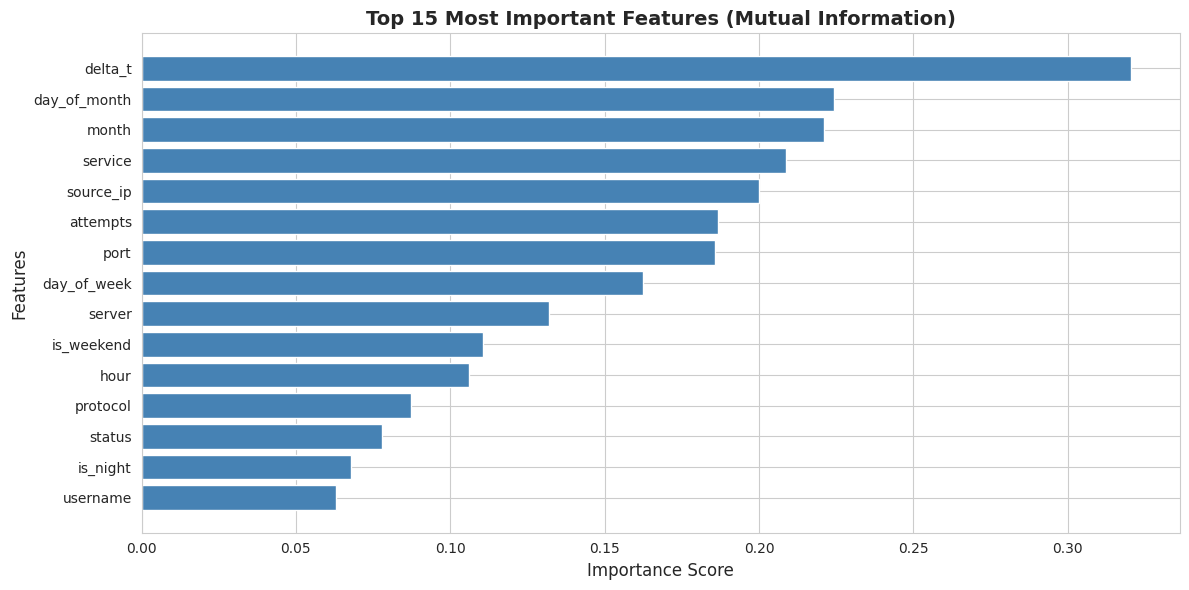

In [7]:
# Visualize feature importance
plt.figure(figsize=(12, 6))
top_features = feature_scores.head(15)
plt.barh(range(len(top_features)), top_features['Score'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Most Important Features (Mutual Information)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# # 5. Dimensionality Reduction with PCA


In [8]:
print("\n" + "="*80)
print("DIMENSIONALITY REDUCTION (PCA)")
print("="*80)

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_selected)
X_val_pca = pca.transform(X_val_selected)
X_test_pca = pca.transform(X_test_selected)

print(f"✓ Original features: {X_train_selected.shape[1]}")
print(f"✓ PCA components: {pca.n_components_}")
print(f"✓ Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"✓ Final train shape: {X_train_pca.shape}")

# Save PCA
joblib.dump(pca, 'pca.pkl')
print("✓ PCA model saved as 'pca.pkl'")



DIMENSIONALITY REDUCTION (PCA)
✓ Original features: 12
✓ PCA components: 9
✓ Variance explained: 0.9768
✓ Final train shape: (350000, 9)
✓ PCA model saved as 'pca.pkl'


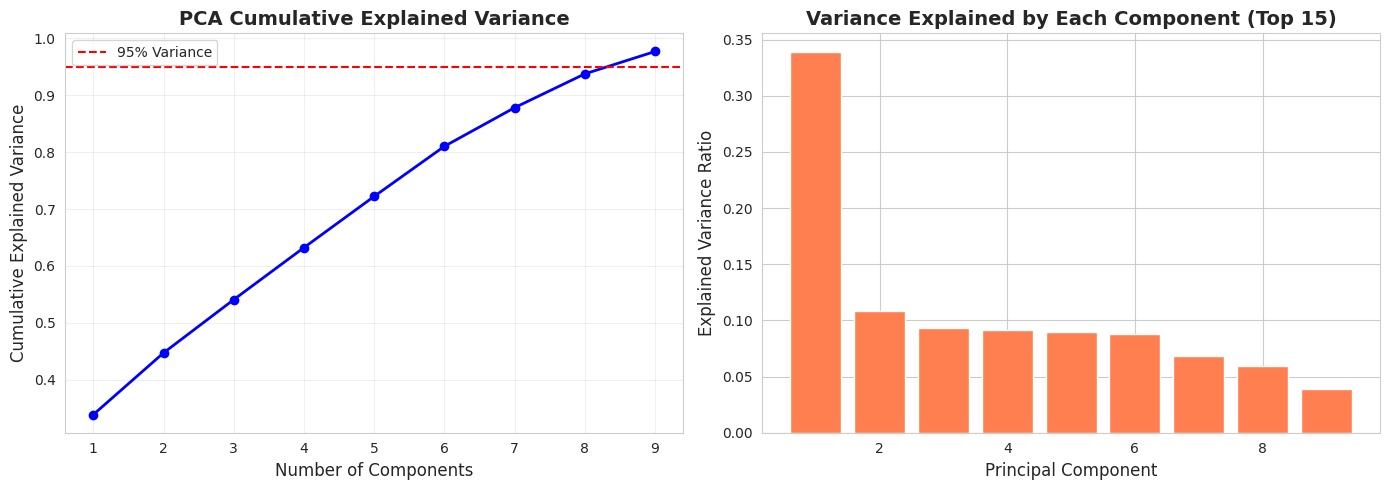

In [9]:
# Visualize explained variance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(1, min(16, len(pca.explained_variance_ratio_) + 1)),
        pca.explained_variance_ratio_[:15], color='coral')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Variance Explained by Each Component (Top 15)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# # 6. Model Training and Validation


In [10]:
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

# Define models
models = {
    'SGD Classifier': SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001,
                                     max_iter=1000, tol=1e-3, random_state=42,
                                     n_jobs=-1, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance',
                                                 metric='minkowski', n_jobs=-1),
    'Linear SVC': LinearSVC(penalty='l2', loss='squared_hinge', C=1.0,
                           max_iter=1000, random_state=42, class_weight='balanced'),
    'Ada Boost Classifier': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Bagging Classifier': BaggingClassifier(n_estimators=10, random_state=42, n_jobs=-1)
}

# Store results
training_results = {}
validation_results = {}
trained_models = {}

print("\nTraining models on training data and validating on validation data...\n")

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)

    # Train the model
    model.fit(X_train_pca, y_train)
    print(f"✓ {model_name} training completed")

    # Predictions on training set
    y_train_pred = model.predict(X_train_pca)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

    # Predictions on validation set
    y_val_pred = model.predict(X_val_pca)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

    # Store results
    training_results[model_name] = {
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1_score': train_f1
    }

    validation_results[model_name] = {
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1_score': val_f1
    }

    trained_models[model_name] = model

    # Print results
    print(f"\nTraining Set Performance:")
    print(f"  Accuracy:  {train_accuracy:.4f}")
    print(f"  Precision: {train_precision:.4f}")
    print(f"  Recall:    {train_recall:.4f}")
    print(f"  F1-Score:  {train_f1:.4f}")

    print(f"\nValidation Set Performance:")
    print(f"  Accuracy:  {val_accuracy:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall:    {val_recall:.4f}")
    print(f"  F1-Score:  {val_f1:.4f}")

    # Check for overfitting
    overfit_score = train_accuracy - val_accuracy
    print(f"\nOverfitting Check: {overfit_score:.4f} (Train - Val Accuracy)")
    if overfit_score > 0.1:
        print("  ⚠️  Warning: Potential overfitting detected")
    else:
        print("  ✓ Model generalizes well")

print("\n" + "="*80)
print("ALL MODELS TRAINED SUCCESSFULLY")

print("="*80)


MODEL TRAINING

Training models on training data and validating on validation data...


Training: SGD Classifier
✓ SGD Classifier training completed

Training Set Performance:
  Accuracy:  0.9994
  Precision: 0.9994
  Recall:    0.9994
  F1-Score:  0.9994

Validation Set Performance:
  Accuracy:  0.9993
  Precision: 0.9993
  Recall:    0.9993
  F1-Score:  0.9993

Overfitting Check: 0.0001 (Train - Val Accuracy)
  ✓ Model generalizes well

Training: K-Nearest Neighbors
✓ K-Nearest Neighbors training completed

Training Set Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Validation Set Performance:
  Accuracy:  0.9996
  Precision: 0.9996
  Recall:    0.9996
  F1-Score:  0.9996

Overfitting Check: 0.0004 (Train - Val Accuracy)
  ✓ Model generalizes well

Training: Linear SVC
✓ Linear SVC training completed

Training Set Performance:
  Accuracy:  0.9998
  Precision: 0.9998
  Recall:    0.9998
  F1-Score:  0.9998

Validation Set Performance:
  

In [11]:
# Create comparison dataframe
print("\n" + "="*80)
print("MODEL COMPARISON - TRAINING VS VALIDATION")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train_Accuracy': [training_results[m]['accuracy'] for m in models.keys()],
    'Val_Accuracy': [validation_results[m]['accuracy'] for m in models.keys()],
    'Train_F1': [training_results[m]['f1_score'] for m in models.keys()],
    'Val_F1': [validation_results[m]['f1_score'] for m in models.keys()],
})

print("\n", comparison_df.to_string(index=False))



MODEL COMPARISON - TRAINING VS VALIDATION

                Model  Train_Accuracy  Val_Accuracy  Train_F1   Val_F1
      SGD Classifier        0.999400       0.99934  0.999397 0.999336
 K-Nearest Neighbors        1.000000       0.99960  1.000000 0.999599
          Linear SVC        0.999800       0.99974  0.999800 0.999739
Ada Boost Classifier        0.998114       0.99630  0.998094 0.996234
  Bagging Classifier        0.999989       0.99990  0.999989 0.999900


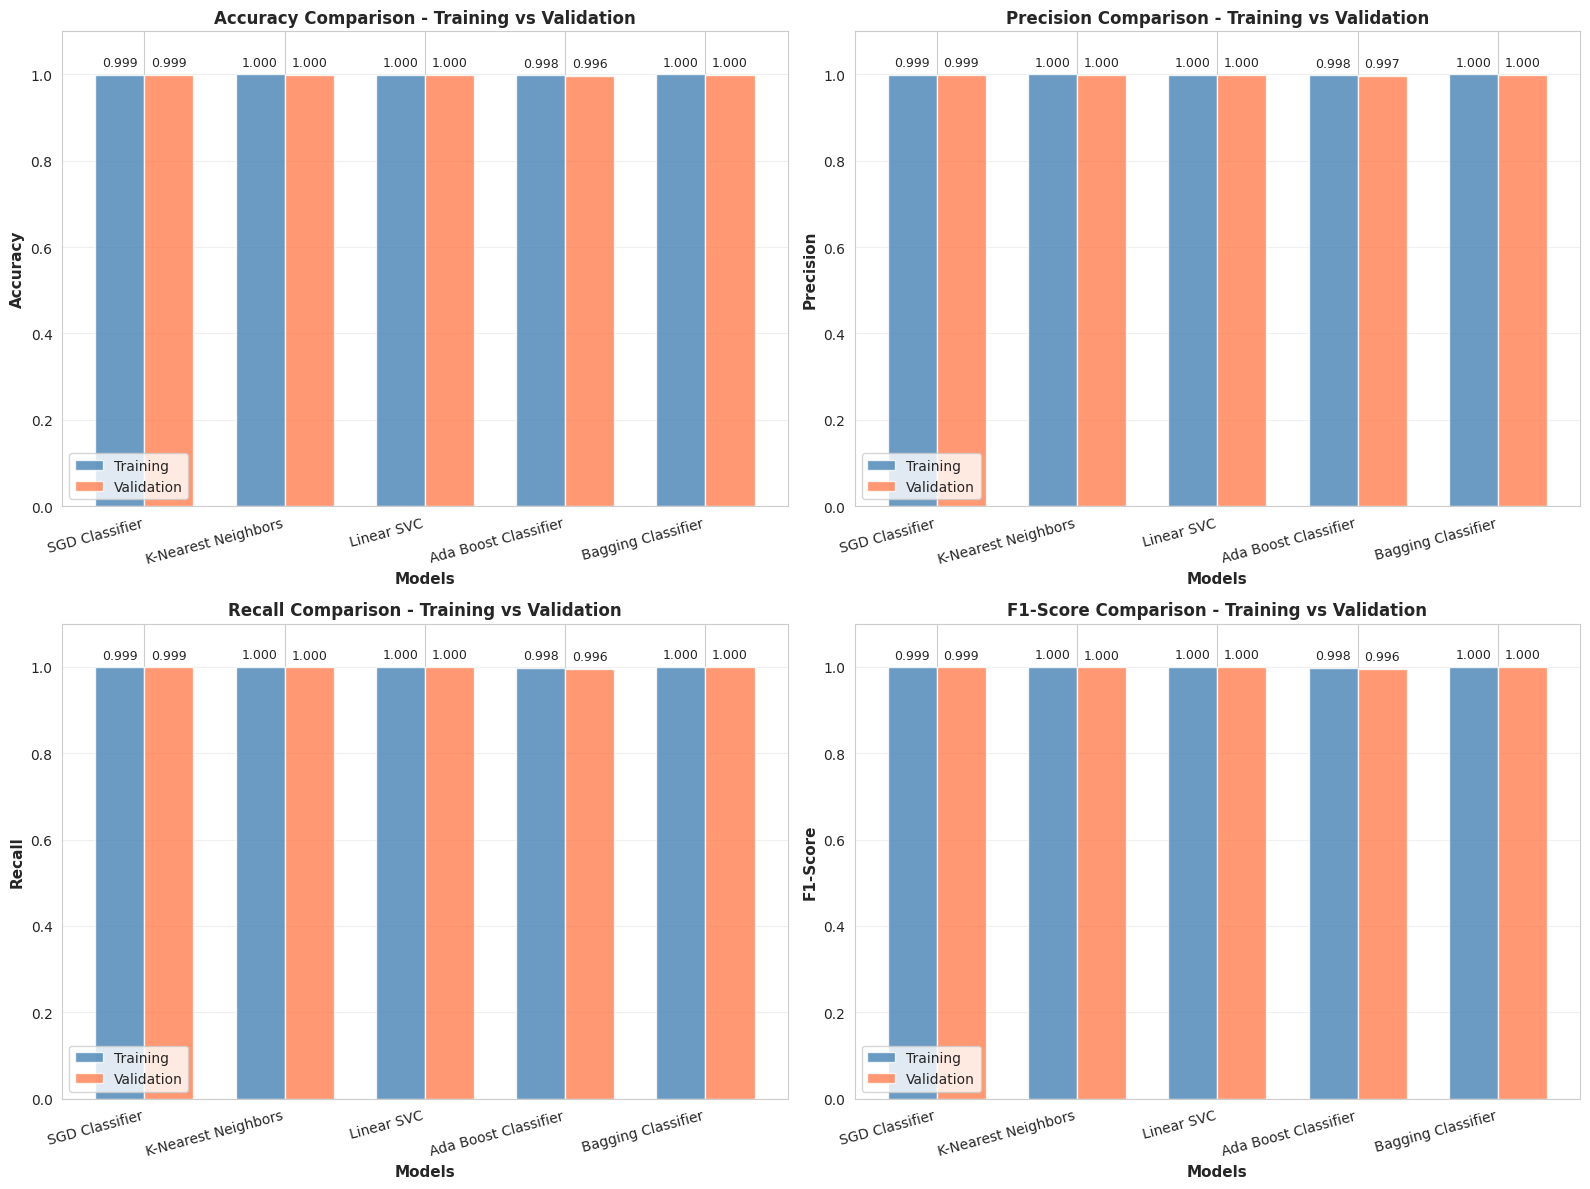

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]

    model_names = list(models.keys())
    train_scores = [training_results[m][metric] for m in model_names]
    val_scores = [validation_results[m][metric] for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    ax.bar(x - width/2, train_scores, width, label='Training', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, val_scores, width, label='Validation', color='coral', alpha=0.8)

    ax.set_xlabel('Models', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} Comparison - Training vs Validation', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

    # Add value labels on bars
    for i, (train_val, val_val) in enumerate(zip(train_scores, val_scores)):
        ax.text(i - width/2, train_val + 0.02, f'{train_val:.3f}', ha='center', fontsize=9)
        ax.text(i + width/2, val_val + 0.02, f'{val_val:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# # 7. Save Trained Models


In [13]:
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

# Save each trained model
for model_name, model in trained_models.items():
    # Create filename
    filename = model_name.lower().replace(' ', '_').replace('-', '_') + '_model.pkl'
    joblib.dump(model, filename)
    print(f"✓ {model_name} saved as '{filename}'")

# Also save the label encoder
joblib.dump(le_target, 'label_encoder.pkl')
print(f"✓ Label encoder saved as 'label_encoder.pkl'")

print("\n✅ All models saved successfully!")



SAVING MODELS
✓ SGD Classifier saved as 'sgd_classifier_model.pkl'
✓ K-Nearest Neighbors saved as 'k_nearest_neighbors_model.pkl'
✓ Linear SVC saved as 'linear_svc_model.pkl'
✓ Ada Boost Classifier saved as 'ada_boost_classifier_model.pkl'
✓ Bagging Classifier saved as 'bagging_classifier_model.pkl'
✓ Label encoder saved as 'label_encoder.pkl'

✅ All models saved successfully!


# # 8. Load Saved Models and Test on Test Data


In [14]:
print("\n" + "="*80)
print("LOADING SAVED MODELS")
print("="*80)

# Load models
loaded_models = {}
model_files = [
    ('SGD Classifier', 'sgd_classifier_model.pkl'),
    ('K-Nearest Neighbors', 'k_nearest_neighbors_model.pkl'),
    ('Linear SVC', 'linear_svc_model.pkl'),
    ('Ada Boost Classifier', 'ada_boost_classifier_model.pkl'),
    ('Bagging Classifier', 'bagging_classifier_model.pkl')
]

for model_name, filename in model_files:
    loaded_models[model_name] = joblib.load(filename)
    print(f"✓ Loaded {model_name} from '{filename}'")

# Load preprocessing objects
scaler_loaded = joblib.load('scaler.pkl')
selector_loaded = joblib.load('feature_selector.pkl')
pca_loaded = joblib.load('pca.pkl')
le_target_loaded = joblib.load('label_encoder.pkl')


print("✓ Loaded all preprocessing objects")


LOADING SAVED MODELS
✓ Loaded SGD Classifier from 'sgd_classifier_model.pkl'
✓ Loaded K-Nearest Neighbors from 'k_nearest_neighbors_model.pkl'
✓ Loaded Linear SVC from 'linear_svc_model.pkl'
✓ Loaded Ada Boost Classifier from 'ada_boost_classifier_model.pkl'
✓ Loaded Bagging Classifier from 'bagging_classifier_model.pkl'
✓ Loaded all preprocessing objects


# # 9. Test Models on Test Data


In [15]:
print("\n" + "="*80)
print("TESTING MODELS ON TEST DATA")
print("="*80)

test_results = {}

for model_name, model in loaded_models.items():
    print(f"\n{'='*60}")
    print(f"Testing: {model_name}")
    print('='*60)

    # Make predictions
    y_test_pred = model.predict(X_test_pca)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    # Store results
    test_results[model_name] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'predictions': y_test_pred
    }

    # Print results
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")

    # Print classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred,
                                target_names=le_target_loaded.classes_,
                                zero_division=0))

print("\n" + "="*80)
print("ALL MODELS TESTED SUCCESSFULLY")
print("="*80)



TESTING MODELS ON TEST DATA

Testing: SGD Classifier

Test Set Performance:
  Accuracy:  0.9994
  Precision: 0.9994
  Recall:    0.9994
  F1-Score:  0.9994

Detailed Classification Report:
                      precision    recall  f1-score   support

         brute_force       1.00      1.00      1.00      2500
         geo_anomaly       1.00      1.00      1.00      2500
              normal       1.00      1.00      1.00     90005
           port_scan       1.00      0.98      0.99      2500
privilege_escalation       1.00      1.00      1.00      2500

            accuracy                           1.00    100005
           macro avg       1.00      1.00      1.00    100005
        weighted avg       1.00      1.00      1.00    100005


Testing: K-Nearest Neighbors

Test Set Performance:
  Accuracy:  0.9997
  Precision: 0.9997
  Recall:    0.9997
  F1-Score:  0.9996

Detailed Classification Report:
                      precision    recall  f1-score   support

         brute_force

In [16]:
# Create final comparison table
print("\n" + "="*80)
print("FINAL MODEL COMPARISON - TRAIN / VALIDATION / TEST")
print("="*80)

final_comparison = pd.DataFrame({
    'Model': list(models.keys()),
    'Train_Acc': [training_results[m]['accuracy'] for m in models.keys()],
    'Val_Acc': [validation_results[m]['accuracy'] for m in models.keys()],
    'Test_Acc': [test_results[m]['accuracy'] for m in models.keys()],
    'Train_F1': [training_results[m]['f1_score'] for m in models.keys()],
    'Val_F1': [validation_results[m]['f1_score'] for m in models.keys()],
    'Test_F1': [test_results[m]['f1_score'] for m in models.keys()],
})

print("\n", final_comparison.to_string(index=False))

# Find best model
best_model_name = max(test_results.keys(), key=lambda x: test_results[x]['f1_score'])
print(f"\n🏆 Best Model (by Test F1-Score): {best_model_name}")
print(f"   Test Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['f1_score']:.4f}")



FINAL MODEL COMPARISON - TRAIN / VALIDATION / TEST

                Model  Train_Acc  Val_Acc  Test_Acc  Train_F1   Val_F1  Test_F1
      SGD Classifier   0.999400  0.99934   0.99942  0.999397 0.999336 0.999417
 K-Nearest Neighbors   1.000000  0.99960   0.99965  1.000000 0.999599 0.999649
          Linear SVC   0.999800  0.99974   0.99986  0.999800 0.999739 0.999860
Ada Boost Classifier   0.998114  0.99630   0.99703  0.998094 0.996234 0.996992
  Bagging Classifier   0.999989  0.99990   0.99994  0.999989 0.999900 0.999940

🏆 Best Model (by Test F1-Score): Bagging Classifier
   Test Accuracy: 0.9999
   Test F1-Score: 0.9999


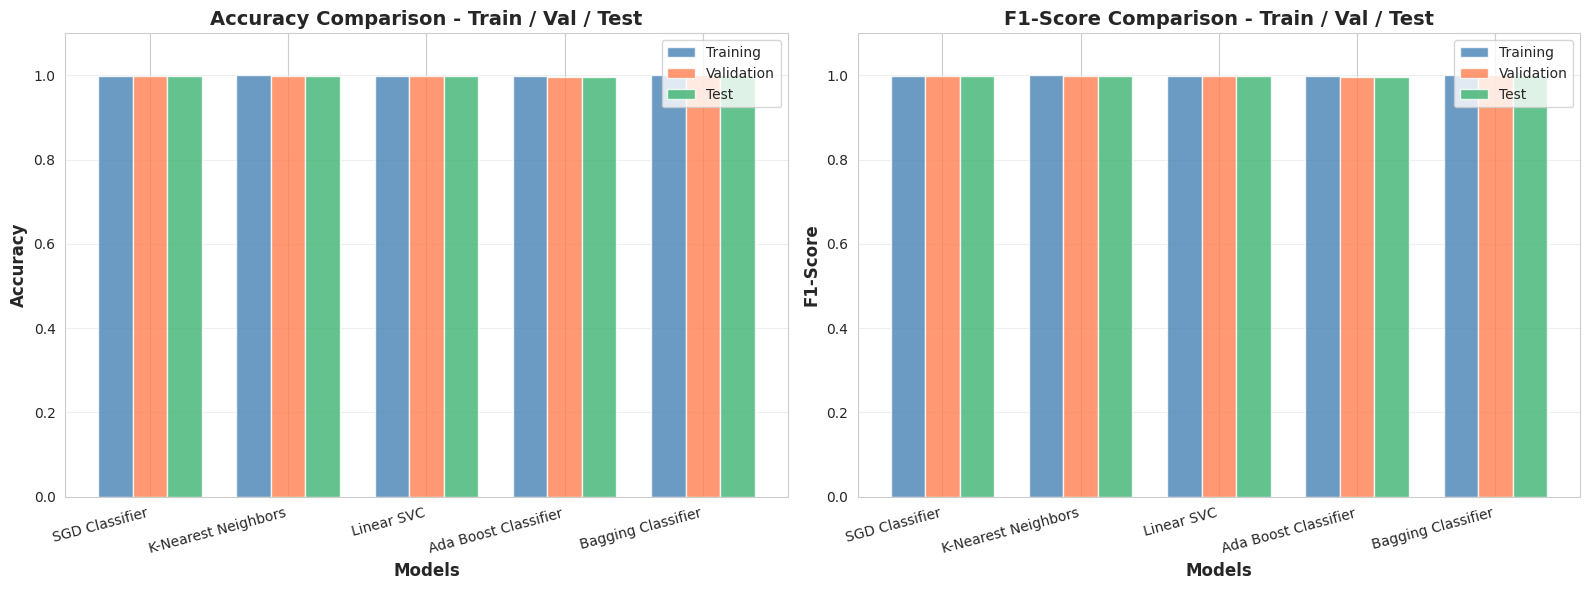

In [17]:
# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
ax1 = axes[0]
model_names = list(models.keys())
train_acc = [training_results[m]['accuracy'] for m in model_names]
val_acc = [validation_results[m]['accuracy'] for m in model_names]
test_acc = [test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

ax1.bar(x - width, train_acc, width, label='Training', color='steelblue', alpha=0.8)
ax1.bar(x, val_acc, width, label='Validation', color='coral', alpha=0.8)
ax1.bar(x + width, test_acc, width, label='Test', color='mediumseagreen', alpha=0.8)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison - Train / Val / Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# F1-Score comparison
ax2 = axes[1]
train_f1 = [training_results[m]['f1_score'] for m in model_names]
val_f1 = [validation_results[m]['f1_score'] for m in model_names]
test_f1 = [test_results[m]['f1_score'] for m in model_names]

ax2.bar(x - width, train_f1, width, label='Training', color='steelblue', alpha=0.8)
ax2.bar(x, val_f1, width, label='Validation', color='coral', alpha=0.8)
ax2.bar(x + width, test_f1, width, label='Test', color='mediumseagreen', alpha=0.8)

ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison - Train / Val / Test', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()


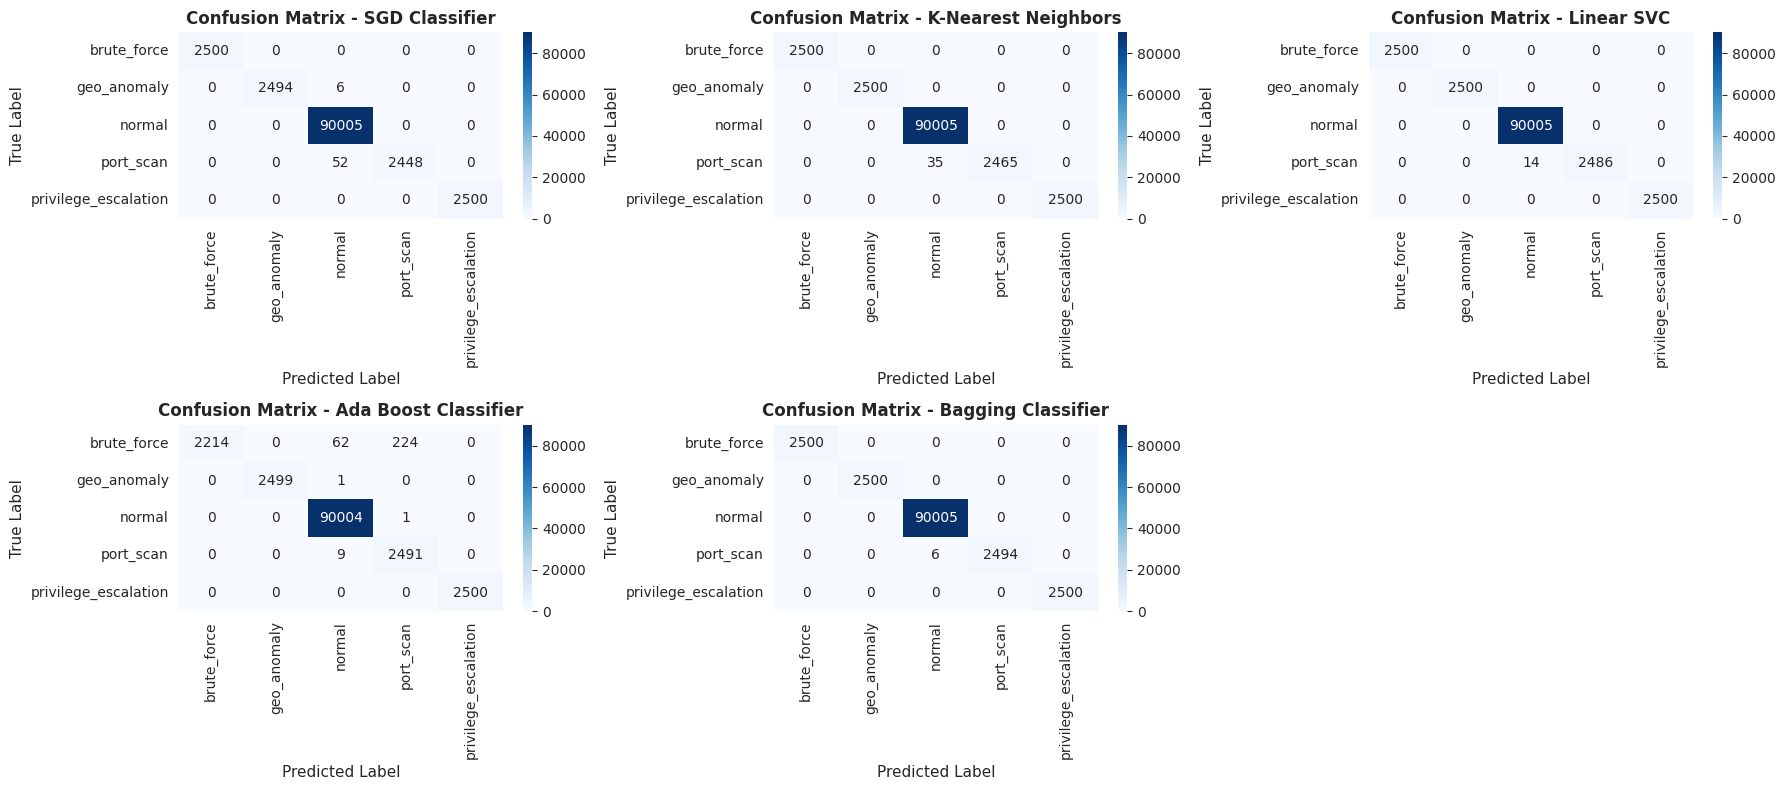

In [18]:
# Confusion matrices for all models
import math

n_models = len(loaded_models)
# Choose up to 3 columns for readability
ncols = min(3, n_models)
nrows = math.ceil(n_models / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

# Flatten axes to 1D array for easy indexing
if isinstance(axes, np.ndarray):
    axes_flat = axes.flatten()
else:
    axes_flat = np.array([axes])

for idx, (model_name, model) in enumerate(loaded_models.items()):
    y_pred = test_results[model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)

    ax = axes_flat[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le_target_loaded.classes_,
                yticklabels=le_target_loaded.classes_)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)

# Turn off any unused subplots (if any)
for j in range(n_models, nrows * ncols):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()


# # 10. ROC Curve Analysis


ROC CURVE ANALYSIS - ONE-VS-REST (OVR) APPROACH

Number of classes: 5
Classes: ['brute_force' 'geo_anomaly' 'normal' 'port_scan' 'privilege_escalation']

Computing ROC curves for: SGD Classifier
  ✓ Using decision_function (shape: (100005, 5))
  - Macro-averaged AUC: 1.0000
  - Individual AUCs per class: ['1.0000', '1.0000', '1.0000', '0.9999', '1.0000']

Computing ROC curves for: K-Nearest Neighbors
  ✓ Using predict_proba (shape: (100005, 5))
  - Macro-averaged AUC: 0.9986
  - Individual AUCs per class: ['1.0000', '1.0000', '0.9986', '0.9944', '1.0000']

Computing ROC curves for: Linear SVC
  ✓ Using decision_function (shape: (100005, 5))
  - Macro-averaged AUC: 0.9999
  - Individual AUCs per class: ['1.0000', '1.0000', '0.9999', '0.9997', '1.0000']

Computing ROC curves for: Ada Boost Classifier
  ✓ Using predict_proba (shape: (100005, 5))
  - Macro-averaged AUC: 0.9997
  - Individual AUCs per class: ['0.9990', '1.0000', '0.9998', '0.9996', '1.0000']

Computing ROC curves for: Bagg

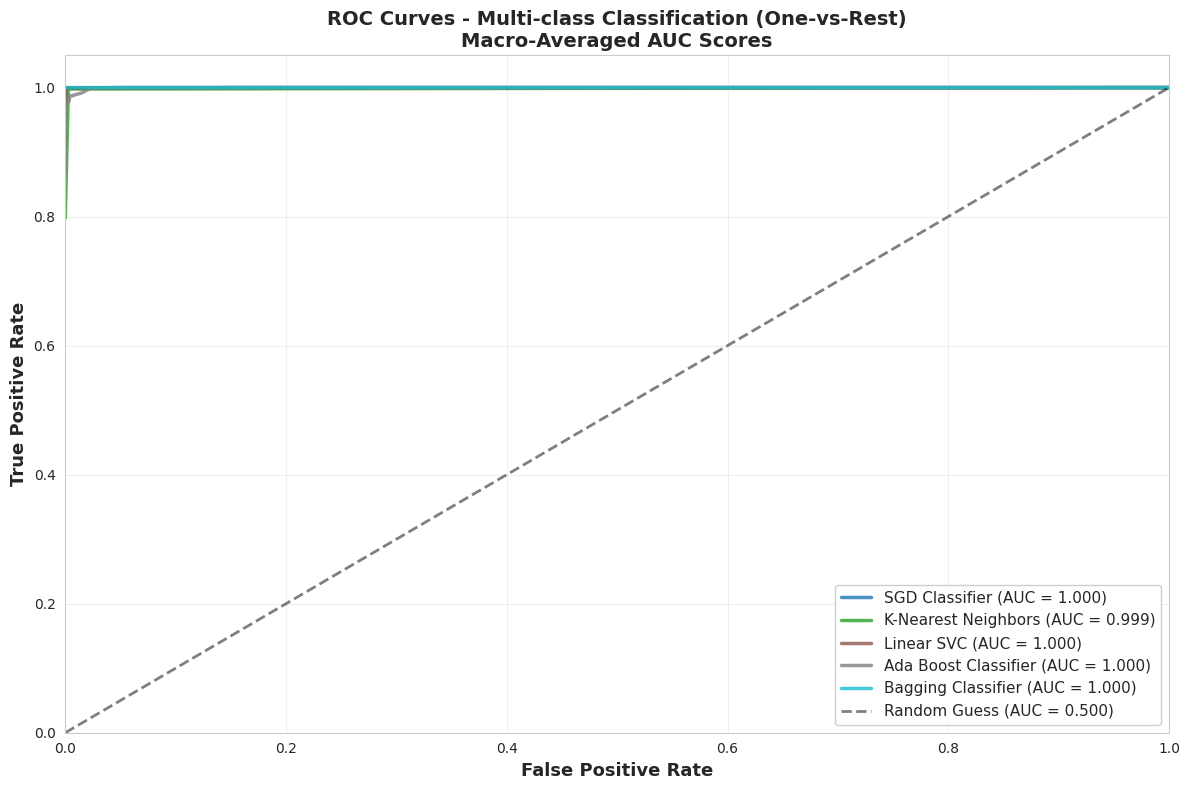


ROC CURVE ANALYSIS COMPLETED

📊 ROC-AUC Summary:
------------------------------------------------------------
               Model  Macro-Averaged AUC
      SGD Classifier            0.999966
 K-Nearest Neighbors            0.998600
          Linear SVC            0.999930
Ada Boost Classifier            0.999695
  Bagging Classifier            1.000000


In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

print("\n" + "="*80)
print("ROC CURVE ANALYSIS - ONE-VS-REST (OVR) APPROACH")
print("="*80)

# Binarize the output for One-vs-Rest approach
y_test_bin = label_binarize(y_test, classes=np.arange(len(le_target_loaded.classes_)))
n_classes = y_test_bin.shape[1]

# Store ROC data for all models
roc_data = {}

# Create figure for ROC curves
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for different models
colors = plt.cm.tab10(np.linspace(0, 1, len(loaded_models)))

print(f"\nNumber of classes: {n_classes}")
print(f"Classes: {le_target_loaded.classes_}\n")

# Compute ROC curves for each model
for model_idx, (model_name, model) in enumerate(loaded_models.items()):
    print(f"Computing ROC curves for: {model_name}")

    # Initialize lists to store ROC data for each class
    fpr_list = []
    tpr_list = []
    auc_list = []

    # Get predictions (probabilities or decision function)
    try:
        # Try to get probability estimates
        y_score = model.predict_proba(X_test_pca)
        print(f"  ✓ Using predict_proba (shape: {y_score.shape})")
    except AttributeError:
        # Use decision function if predict_proba is not available
        y_score = model.decision_function(X_test_pca)
        print(f"  ✓ Using decision_function (shape: {y_score.shape})")

        # For decision_function, if it returns 1D, convert to 2D for binary classification
        if len(y_score.shape) == 1:
            y_score = np.column_stack([1 - y_score, y_score])

    # Compute ROC curve and ROC area for each class (One-vs-Rest)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

    # Compute macro-averaged ROC curve and AUC
    # Interpolate to common x-axis
    all_fpr = np.unique(np.concatenate([fpr_list[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_list[i], tpr_list[i])

    mean_tpr /= n_classes
    mean_auc = np.mean(auc_list)

    # Store ROC data
    roc_data[model_name] = {
        'fpr': all_fpr,
        'tpr': mean_tpr,
        'auc': mean_auc,
        'individual_aucs': auc_list
    }

    # Plot ROC curve for this model
    ax.plot(all_fpr, mean_tpr,
            label=f'{model_name} (AUC = {mean_auc:.3f})',
            linewidth=2.5, color=colors[model_idx], alpha=0.8)

    print(f"  - Macro-averaged AUC: {mean_auc:.4f}")
    print(f"  - Individual AUCs per class: {[f'{auc_val:.4f}' for auc_val in auc_list]}\n")

# Plot random guess reference line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess (AUC = 0.500)', alpha=0.5)

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - Multi-class Classification (One-vs-Rest)\nMacro-Averaged AUC Scores',
             fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ROC CURVE ANALYSIS COMPLETED")
print("="*80)

# Summary table
print("\n📊 ROC-AUC Summary:")
print("-" * 60)
roc_summary = pd.DataFrame({
    'Model': list(roc_data.keys()),
    'Macro-Averaged AUC': [roc_data[m]['auc'] for m in roc_data.keys()]
})
print(roc_summary.to_string(index=False))


# # 11. Final Summary


In [20]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n📊 Dataset Information:")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Validation samples: {len(X_val)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Original features: {train_data.shape[1] - 1}")
print(f"   - Engineered features: {X_train.shape[1]}")
print(f"   - Selected features: {X_train_selected.shape[1]}")
print(f"   - PCA components: {X_train_pca.shape[1]}")

print("\n🔧 Preprocessing Pipeline:")
print("   ✓ Feature Engineering (time-based features)")
print("   ✓ Label Encoding (categorical variables)")
print("   ✓ Standard Scaling")
print(f"   ✓ Feature Selection (kept top {n_features_to_keep} features)")
print(f"   ✓ PCA (retained {pca.explained_variance_ratio_.sum():.2%} variance)")

print("\n🤖 Models Trained:")
for model_name in models.keys():
    print(f"   ✓ {model_name}")

print("\n💾 Saved Files:")
print("   - scaler.pkl")
print("   - feature_selector.pkl")
print("   - pca.pkl")
print("   - label_encoder.pkl")
print("   - sgd_classifier_model.pkl")
print("   - k_nearest_neighbors_model.pkl")
print("   - linear_svc_model.pkl")
print("   - ada_boost_classifier_model.pkl")
print("   - bagging_classifier_model.pkl")

print("\n🏆 Best Performing Model:")
print(f"   Model: {best_model_name}")
print(f"   Test Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print(f"   Test Precision: {test_results[best_model_name]['precision']:.4f}")
print(f"   Test Recall: {test_results[best_model_name]['recall']:.4f}")
print(f"   Test F1-Score: {test_results[best_model_name]['f1_score']:.4f}")

print("\n" + "="*80)
print("✅ MACHINE LEARNING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)



FINAL SUMMARY REPORT

📊 Dataset Information:
   - Training samples: 350000
   - Validation samples: 49995
   - Test samples: 100005
   - Original features: 11
   - Engineered features: 15
   - Selected features: 12
   - PCA components: 9

🔧 Preprocessing Pipeline:
   ✓ Feature Engineering (time-based features)
   ✓ Label Encoding (categorical variables)
   ✓ Standard Scaling
   ✓ Feature Selection (kept top 12 features)
   ✓ PCA (retained 97.68% variance)

🤖 Models Trained:
   ✓ SGD Classifier
   ✓ K-Nearest Neighbors
   ✓ Linear SVC
   ✓ Ada Boost Classifier
   ✓ Bagging Classifier

💾 Saved Files:
   - scaler.pkl
   - feature_selector.pkl
   - pca.pkl
   - label_encoder.pkl
   - sgd_classifier_model.pkl
   - k_nearest_neighbors_model.pkl
   - linear_svc_model.pkl
   - ada_boost_classifier_model.pkl
   - bagging_classifier_model.pkl

🏆 Best Performing Model:
   Model: Bagging Classifier
   Test Accuracy: 0.9999
   Test Precision: 0.9999
   Test Recall: 0.9999
   Test F1-Score: 0.9999
